## Imports

In [25]:
# imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score, f1_score, precision_score, recall_score,
    confusion_matrix, ConfusionMatrixDisplay, classification_report
)
from sklearn.neural_network import MLPClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import GridSearchCV

## Define Functions

In [26]:
# define evaluation function
def evaluate(y_pred):
    accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)

    conf_mat = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=conf_mat)
    
    print("Accuracy:    ", accuracy)
    print("F1-Score:    ", f1)
    print("Precision:   ", precision)
    print("Recall:      ", recall)
    print()
    print(classification_report(y_test, y_pred))
    print()

    disp.plot()

## Load .csv into DF

In [27]:
# load data into dataframe
df = pd.read_csv("phishing_email_projectthesis.csv") 

## Prepare Data

In [28]:
# rename columns
df = df.rename(columns={'text_combined': 'content'}).rename(columns={'label': 'target'}) 

In [29]:
# drop duplicates but keep the first
df = df.drop_duplicates(keep='first') 

In [30]:
# randomized undersampling
df = df.groupby('target').apply(lambda x: x.sample(39233, replace=True, random_state=42)).reset_index(drop=True)

/var/folders/gr/nkq2fp191y1_3wywjp14_sz00000gn/T/ipykernel_1722/842751370.py:2: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = df.groupby('target').apply(lambda x: x.sample(39233, replace=True, random_state=42)).reset_index(drop=True)


## Split Data into Training and Test 80-20

In [31]:
# define X and Y
X = df['content']
y = df['target']

# split data 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# check the shape
print("Shape of X_train:", X_train.shape)
print("Shape of X_test:", X_test.shape)
print("Shape of y_train:", y_train.shape)
print("Shape of y_test:", y_test.shape)

Shape of X_train: (62772,)
Shape of X_test: (15694,)
Shape of y_train: (62772,)
Shape of y_test: (15694,)


## Vektorize with TF-IDF

In [32]:
# creating vectorizer object with standart parameters
vectorizer = TfidfVectorizer()

# fit on and tranform training data
X_train_tfidf = vectorizer.fit_transform(X_train)

# transform test data 
X_test_tfidf = vectorizer.transform(X_test)

## Multi Layer Perceptron

/Users/nikobiebl/.local/share/virtualenvs/Project-Thesis-PGQKRxl5/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (3) reached and the optimization hasn't converged yet.
  warnings.warn(


Accuracy:     0.9966229132152415
F1-Score:     0.9966145001596934
Precision:    0.9966781653251565
Recall:       0.9965508431272355

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      7866
           1       1.00      1.00      1.00      7828

    accuracy                           1.00     15694
   macro avg       1.00      1.00      1.00     15694
weighted avg       1.00      1.00      1.00     15694




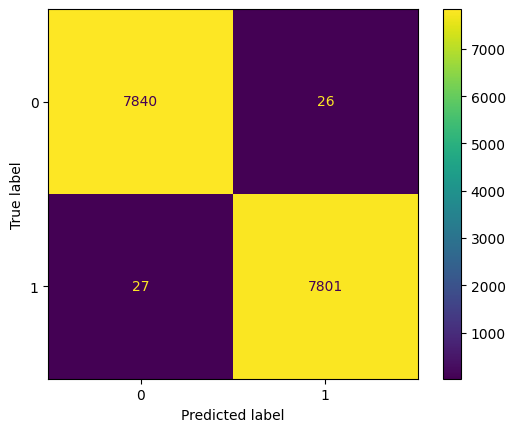

In [67]:
# create classifier object
mlp_tfidf_classifier = MLPClassifier(hidden_layer_sizes=(100, 50, 25), max_iter=3,random_state=42)

# train classifier
mlp_tfidf_classifier.fit(X_train_tfidf, y_train)

# test classifier
mlp_tfidf_predictions = mlp_tfidf_classifier.predict(X_test_tfidf)

# evaluate
evaluate(mlp_tfidf_predictions)

## Creating Treshold Evaluation

In [68]:
probabilities = mlp_tfidf_classifier.predict_proba(X_test_tfidf)

probabilities_0 = probabilities[:, 0]
probabilities_1 = probabilities[:, 1]

actual_values = y_test

probabilities_and_values_df = pd.DataFrame({
    'probabilities_0': probabilities_0,
    'probabilities_1': probabilities_1,
    'actual_values': actual_values
})

print(probabilities_and_values_df.shape)
print(probabilities_and_values_df.head(20))

(15694, 3)
       probabilities_0  probabilities_1  actual_values
30578     9.999996e-01     4.257627e-07              0
75285     4.942060e-06     9.999951e-01              1
47368     2.690850e-04     9.997309e-01              1
23969     9.999992e-01     7.657249e-07              0
53099     1.284532e-04     9.998715e-01              1
14076     9.999638e-01     3.622599e-05              0
20565     9.999573e-01     4.267212e-05              0
62974     2.867437e-04     9.997133e-01              1
55285     3.864819e-06     9.999961e-01              1
61165     2.257115e-05     9.999774e-01              1
49031     6.793244e-05     9.999321e-01              1
65834     3.878543e-05     9.999612e-01              1
64319     6.233042e-05     9.999377e-01              1
63695     8.265674e-07     9.999992e-01              1
77050     1.207835e-05     9.999879e-01              1
15197     9.999929e-01     7.085141e-06              0
9908      9.999989e-01     1.063104e-06              0

In [69]:
under_60_percent_df = probabilities_and_values_df[(probabilities_and_values_df['probabilities_0'] < 0.6) & (probabilities_and_values_df['probabilities_1'] < 0.60)]

print(under_60_percent_df.shape)
print(under_60_percent_df.head(22))

(12, 3)
       probabilities_0  probabilities_1  actual_values
54700         0.409622         0.590378              1
30282         0.577353         0.422647              0
18138         0.593944         0.406056              0
23754         0.579275         0.420725              0
10684         0.512805         0.487195              0
5134          0.539286         0.460714              0
62753         0.573629         0.426371              1
62644         0.426463         0.573537              1
23131         0.542855         0.457145              0
55352         0.418154         0.581846              1
27859         0.579275         0.420725              0
67181         0.571704         0.428296              1


In [70]:
thresholds = np.arange(0.5, 1.0, 0.01)

results = []

for threshold in thresholds:

    classifiable_df = probabilities_and_values_df[(probabilities_and_values_df['probabilities_0'] > threshold) | (probabilities_and_values_df['probabilities_1'] > threshold)]
    
    percentage_classifiable = (len(classifiable_df) / len(probabilities_and_values_df)) * 100
    
    predicted_labels = np.where(classifiable_df['probabilities_1'] > threshold, 1, 0)

    accuracy = accuracy_score(classifiable_df['actual_values'], predicted_labels) * 100
    precision = precision_score(classifiable_df['actual_values'], predicted_labels) * 100
    recall = recall_score(classifiable_df['actual_values'], predicted_labels) * 100
    f1 = f1_score(classifiable_df['actual_values'], predicted_labels) * 100

    results.append({
        'threshold': threshold,
        'classifiable': percentage_classifiable,
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1
    })

results_df = pd.DataFrame(results)

print(results_df.head(50))

    threshold  classifiable   accuracy  precision     recall         f1
0        0.50    100.000000  99.662291  99.667817  99.655084  99.661450
1        0.51    100.000000  99.662291  99.667817  99.655084  99.661450
2        0.52     99.993628  99.662270  99.667817  99.655084  99.661450
3        0.53     99.993628  99.662270  99.667817  99.655084  99.661450
4        0.54     99.987256  99.662248  99.667817  99.655084  99.661450
5        0.55     99.980884  99.662227  99.667817  99.655084  99.661450
6        0.56     99.980884  99.662227  99.667817  99.655084  99.661450
7        0.57     99.980884  99.662227  99.667817  99.655084  99.661450
8        0.58     99.942653  99.674849  99.667774  99.680511  99.674142
9        0.59     99.936281  99.674828  99.667732  99.680470  99.674101
10       0.60     99.923538  99.674786  99.667689  99.680430  99.674059
11       0.61     99.917166  99.674766  99.667647  99.680389  99.674017
12       0.62     99.904422  99.681102  99.680389  99.680389  99